In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import wandb
import gymnasium as gym

from aux_task_discovery.utils.constants import WANDB_PROJECT, WANDB_ENTITY

In [3]:
# Set Sweep ID
SWEEP_ID = "n89duw92"

In [4]:
# Query W&B API for sweep runs
api = wandb.Api()
sweep = api.sweep(WANDB_ENTITY + "/" + WANDB_PROJECT + "/" + SWEEP_ID)
sweep_runs = sweep.runs

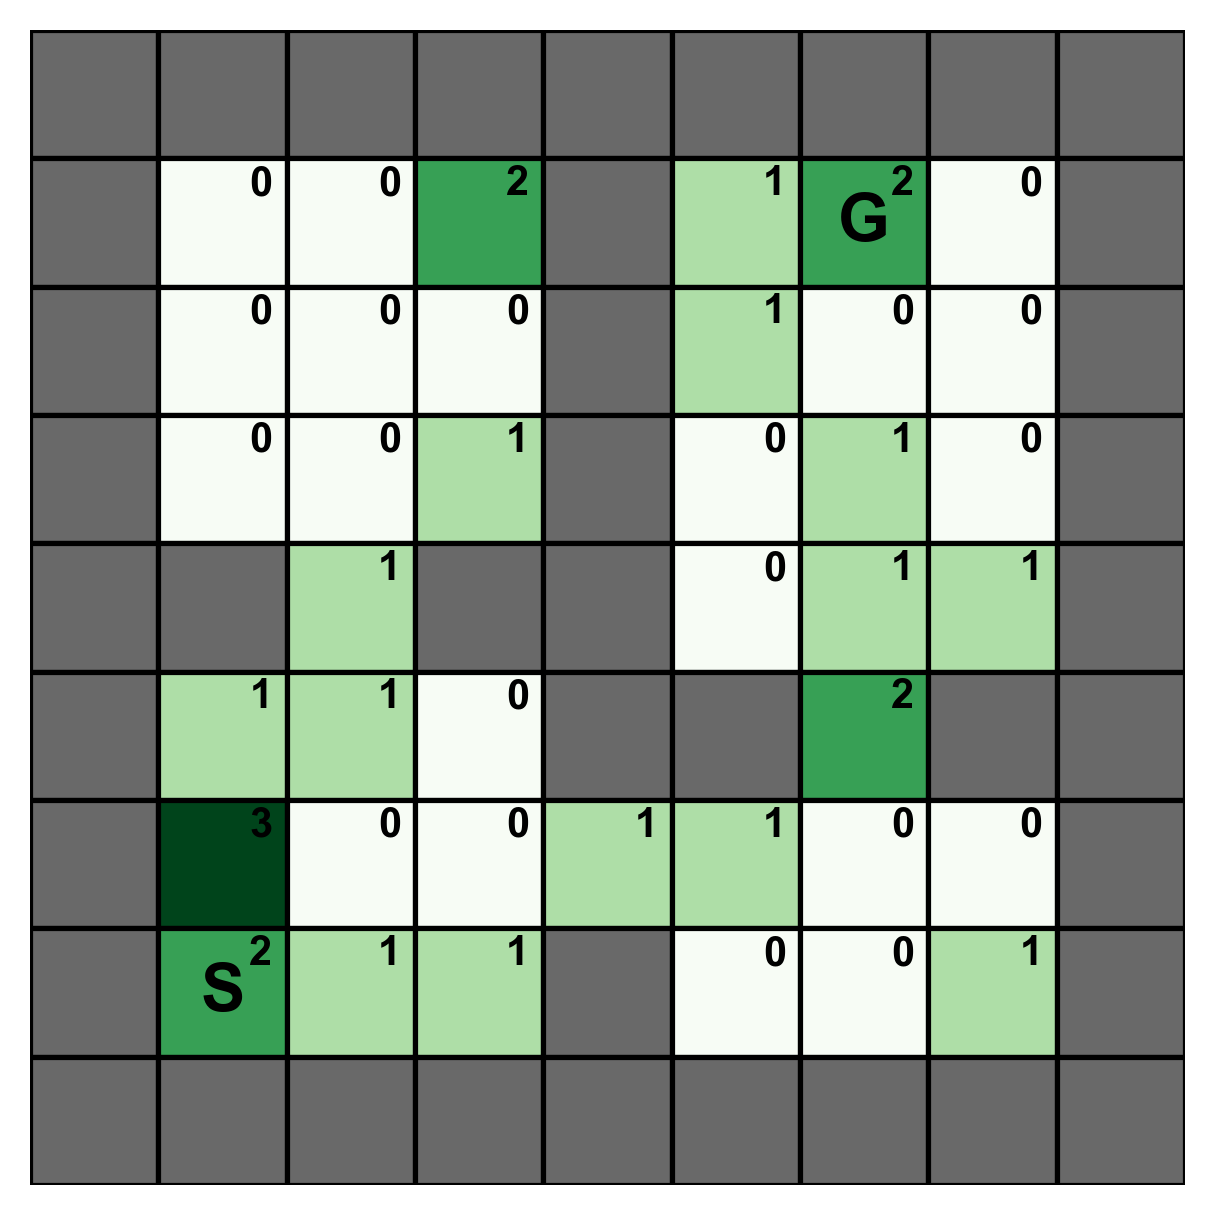

In [5]:
# Plot frequency of preservation for each valid subgoal across all runs in the sweep
# Note that this assumes that all runs in the sweep have the same environment and number of aux tasks
# This is only to be used for the same experiment repeated with different seeds

n_aux_tasks = sweep_runs[0].config['agent_args']['n_aux_tasks']
env_name = sweep_runs[0].config['env']
gridworld_env = gym.make(env_name)
obs_size = gridworld_env.unwrapped.observation_space.shape[0]

# Get the total number of times each subgoal was preserved across all runs in the sweep
subgoal_counts = [0 for _ in range(obs_size)]
for run in sweep_runs:
    assert run.config['agent_args']['n_aux_tasks'] == n_aux_tasks, 'All runs must have same number of aux tasks'
    assert run.config['env'] == env_name, 'All runs must have same environment'
    for i in range(n_aux_tasks):
        subgoal_idx = run.history()[f'aux_{i+1}_subgoal'].iloc[-1]
        subgoal_counts[subgoal_idx] += 1

# Reshape to grid shape
dim = gridworld_env.unwrapped.size
subgoal_counts = np.array(subgoal_counts).reshape(dim, dim)

# Normalize the counts to be between 0 and 1
norm_subgoal_counts = subgoal_counts / np.max(subgoal_counts)

# Create the figure and axis
fig, ax = plt.subplots(dpi=300, figsize=(5,5))

# Create a colormap object
cmap = mpl.colormaps.get_cmap('Greens')

# Plot grid with cell colors corresponding to total number of times the subgoal was preserved across all runs in the sweep 
for i in range(dim+2):
    for j in range(dim+2):
        # Set walls to grey
        if i == 0 or i == dim + 1 or j == 0 or j == dim + 1: # Wall
            color = 'dimgrey'
        else:
            # Adjust the indices to match the actual grid cells
            grid_i = i - 1
            grid_j = j - 1
            # Set obstacles to grey
            if gridworld_env.unwrapped.is_obstacle((grid_i,grid_j)):
                color = 'dimgrey'
            else:
                # Regular cell color corresponds to total number of times the subgoal was preserved
                color = cmap(norm_subgoal_counts[grid_i,grid_j])
                # Add text for number of times the subgoal was preserved
                if (grid_i,grid_j) in [gridworld_env.unwrapped.start_pos, gridworld_env.unwrapped.goal_pos]:
                    ax.text(j+0.8, dim + 1 - i + 0.8, subgoal_counts[grid_i,grid_j], fontsize=10, fontweight='bold', fontname='Arial', ha='center', va='center')
                else:
                    ax.text(j+0.8, dim + 1 - i + 0.8, subgoal_counts[grid_i,grid_j], fontsize=10, fontweight='bold', fontname='Arial', ha='center', va='center')
            # Add text for start position
            if (grid_i,grid_j) == gridworld_env.unwrapped.start_pos:
                ax.text(j+0.5, dim + 1 - i + 0.5, 'S', fontsize=16, fontweight='bold', fontname='Arial', ha='center', va='center')
            # Add text for goal position
            if (grid_i,grid_j) == gridworld_env.unwrapped.goal_pos:
                ax.text(j+0.5, dim + 1 - i + 0.5, 'G', fontsize=16, fontweight='bold', fontname='Arial', ha='center', va='center')
        # Create a rectangle
        rect = patches.Rectangle((j, dim + 1 - i), 1, 1, facecolor=color, edgecolor='black', linewidth=1.25)
        # Add the rectangle to the plot
        ax.add_patch(rect)
# Set the limits and aspect ratio
ax.set_xlim(0, dim+2)
ax.set_ylim(0, dim+2)
ax.set_aspect('equal')

# Remove the axes
ax.axis('off')

plt.show()
